## Методические указания по выполнению лабораторной работы №3

**Тема: Обнаружение объектов с использованием Faster R-CNN**

**Цель работы:** Ознакомиться с архитектурой Faster R-CNN и принципами двухэтапного обнаружения объектов.

**Задачи:**
- Изучить теоретические основы двухэтапного обнаружения объектов: роль RPN и классификационного этапа в Faster R-CNN.
- Загрузить предобученную модель Faster R-CNN.
- Ознакомиться с форматом аннотаций для обучения в задаче детекции.
- Визуализировать предсказания, проанализировать ошибки модели и провести исследование по поиску баланса FN/FP.

### 1. Теоретическая часть

В данной лабораторной работе мы познакомимся с задачей детекции на примере архитектуры [Faster R-CNN](https://arxiv.org/pdf/1506.01497), обученной на наборе данных [COCO](https://cocodataset.org/#home), а также с новым форматом данных для обучения нейро-сетевых моделей детекции. Для оценки модели воспользуемся набором данных [Pascal VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/).

**Перед тем, как приступать к выполнению практической части, ознакомьтесь с первоисточниками используемых компонентов, а также документацией по [ссылке](https://pytorch.org/vision/master/models/faster_rcnn.html), включающей подробности работы с моделью и новым форматом данных, сэмплы кода.**

#### 1.1 Архитектура Faster R-CNN

Существует два основных подхода к обнаружению объектов:
Двухстадийные модели – более точные, но медленные.
Одностадийные модели – быстрые, но менее точные.

Faster R-CNN — это двухэтапная модель детекции объектов. В отличие от ResNeXt, Faster R-CNN не просто классифицирует изображение, а находит на нём несколько объектов, предсказывает bounding boxes и присваивает метки классам. Она состоит из следующих компонентов:

1. Backbone (ResNet/VGG/MobileNet) – извлекает признаки из изображения.
2. Region Proposal Network (RPN) – предлагает области, где могут находиться объекты.
3. ROI Pooling + Fully Connected Layers – классифицирует объекты и уточняет bounding boxes.
4. Non-Maximum Suppression (NMS) – убирает дублирующиеся предсказания.


В предыдущих лабораторных работах мы познакомились с классификацией изображений, где модель предсказывает единственный класс для всего изображения. Однако во многих задачах компьютерного зрения классификация недостаточна. Например, когда на одном изображении присутствуют несколько объектов разных классов необходимо не только определить, что изображено, но и где это находится.

Faster R-CNN –  модель, которая также решает задачу обнаружения объектов, добавляя к классификации локализацию.

#### 1.2 Формат данных для задачи детекции

Faster R-CNN требует разметки изображений, помимо классов включающей в себя и координаты bounding box по оси x, y.
Ознакомьтесь с форматом набора данных Pascal VOC, скачайте аннотации набора данных и изучите структуру **.xml** файлов в папке Annotations по [ссылке](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtestnoimgs_06-Nov-2007.tar).

#### 1.3 Оценка качества

Помимо известных вам инструментов оценить качество работы детектора могут помочь:

Confidence Score - значение, указывающее на уверенность модели в том, что на данном месте изображения находится объект. Модель предсказывает этот параметр для каждого предсказанного bounding box. Чем выше confidence score, тем более уверена модель в своём предсказании.

Фильтрация предсказаний - модель может предсказать много объектов, но не все из них будут точными. Чтобы уменьшить количество ложных срабатываний (False Positives), применяется фильтр предсказаний, используя confidence threshold. Если confidence score меньше заданного порога - предсказание отбрасывается.


### 2. Практическая часть

#### 2.1 Подготовка окружения

Установите зависимости и библиотеки:

In [ ]:
import torch
import torch.nn.functional as F
from torchvision.transforms import functional as P
import torchvision.transforms as transforms
import torchvision.utils
from torchvision import models, datasets
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Используемое устройство:", device)

Используемое устройство: cuda


#### 2.2 Подготовка модели

Загрузите предобученную модель, определите устройство, переведите модель в режим инференса:

In [ ]:
# импорт модели
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Переводим модель в режим инференса
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
print("input: ", in_features)

out_features = model.roi_heads.box_predictor.cls_score.out_features
print("out: ", out_features)

model = model.to(device)

input:  1024
out:  91


#### 2.3 Загрузка и предобработка изображений


Затем импортируйте датасет из соответствующих пакетов PyTorch и определите метод трансформации данных для подачи в модель. Он понадобится позже для преобразования изображений при прямом проходе через модель чтобы получить предсказания:

In [ ]:
def collate_fn(batch):
    images, targets = zip(*batch)
    images_resized = [P.resize(img, (800, 1333)) for img in images]
    images_tensor = torch.stack([F.to_tensor(img) if not isinstance(img, torch.Tensor) else img for img in images_resized], dim=0)

    return images_tensor, targets

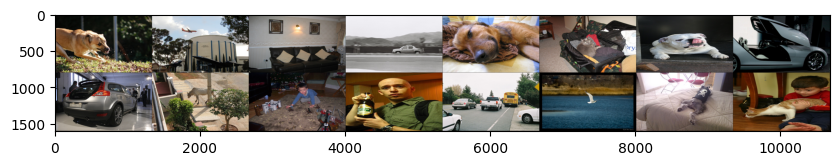

In [ ]:
# объявите метод трансформации, включающий в себя изменение размера, приведение к тензору и нормализацию
transform = transforms.Compose([
   transforms.ToTensor()
])

#train_dataset = datasets.VOCDetection(root="./data", year="2007", image_set="train", download=True, transform=transform)
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

test_dataset = datasets.VOCDetection(root="./data", year="2007", image_set="test", download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

def imshow(img, figsize=(10, 10)):
    npimg = img.numpy()

    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


images, labels = next(iter(test_loader))
imshow(torchvision.utils.make_grid(images), figsize=(10, 10))

### Mapping Coco classes to Pascal VOC 2007

In [ ]:
import ast
from itertools import islice

with open("ms_coco_classnames.txt", "r") as file:
    coco_dict = ast.literal_eval(file.read())

for key, value in islice(coco_dict.items(), 5):
    print(key, value)

0 __background__
1 person
2 bicycle
3 car
4 motorcycle


In [ ]:
def map_coco_to_pascal_VOC(coco_name):
    name = coco_name.lower()

    if "airplane" in name or "jet" in name or "warplane" in name:
        return "aeroplane"
    elif "bicycle" in name or "bike" in name:
        return "bicycle"
    elif "bird" in name or "robin" in name or "sparrow" in name:
        return "bird"
    elif "boat" in name or "ship" in name or "vessel" in name:
        return "boat"
    elif "bottle" in name or "flask" in name:
        return "bottle"
    elif "bus" in name:
        return "bus"
    elif "car" in name or "automobile" in name or "limousine" in name:
        return "car"
    elif "cat" in name:
        return "cat"
    elif "chair" in name or "seat" in name:
        return "chair"
    elif "cow" in name or "bull" in name:
        return "cow"
    elif "dining table" in name or "table" in name:
        return "diningtable"
    elif "dog" in name or "hound" in name or "puppy" in name:
        return "dog"
    elif "horse" in name or "stallion" in name:
        return "horse"
    elif "motorcycle" in name or "motorbike" in name:
        return "motorbike"
    elif "person" in name or "human" in name:
        return "person"
    elif "potted plant" in name or "plant" in name or "flowerpot" in name:
        return "pottedplant"
    elif "sheep" in name or "lamb" in name:
        return "sheep"
    elif "sofa" in name or "couch" in name or "settee" in name:
        return "sofa"
    elif "train" in name or "locomotive" in name:
        return "train"
    elif "tv" in name or "monitor" in name or "screen" in name:
        return "tvmonitor"
    elif "background" in name:
      return "background"
    else:
        return None

In [ ]:
voc_classes = [
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car",
    "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

In [ ]:
def coco_to_pascal_VOC_prediction(labels, scores, boxes, coco_names, threshold=0.5):
    keep = scores >= threshold

    filtered_labels = labels[keep]
    filtered_scores = scores[keep]
    filtered_boxes = boxes[keep]

    voc_class_idxs = []
    mapped_scores = []
    mapped_boxes = []

    for coco_class_id, score, box in zip(filtered_labels.cpu().numpy(), filtered_scores.cpu().numpy(), filtered_boxes.cpu().numpy()):
        if coco_class_id < len(coco_names):
            mapped_class = map_coco_to_pascal_VOC(coco_names[coco_class_id])

            if mapped_class is not None:
                voc_class_idx = voc_classes.index(mapped_class)

                voc_class_idxs.append(voc_class_idx)
                mapped_scores.append(score)
                mapped_boxes.append(box)

    return voc_class_idxs, mapped_scores, mapped_boxes

#### 2.4 Объявление методов для работы с данными

Далее необходимо создать методы препроцессинга: метод чтения файла аннотации для возврата numpy-объекта содержащего bounding boxes, и метод отрисовки истиных и прогнозных bounding boxes на изображении для визуализации полученных результатов.

In [16]:
from PIL import Image, ImageDraw, ImageFont
import xml.etree.ElementTree as ET

class_to_idx = {
    "aeroplane": 1, "bicycle": 2, "bird": 3, "boat": 4, "bottle": 5,
    "bus": 6, "car": 7, "cat": 8, "chair": 9, "cow": 10,
    "diningtable": 11, "dog": 12, "horse": 13, "motorbike": 14, "person": 15,
    "pottedplant": 16, "sheep": 17, "sofa": 18, "train": 19, "tvmonitor": 20
}

def parse_voc_annotation(xml_path, class_to_idx):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    boxes = []
    labels = []

    for obj in root.findall("object"):
        name = obj.find("name").text  # Get class label
        bbox = obj.find("bndbox")
        xmin, ymin, xmax, ymax = (int(bbox.find("xmin").text), int(bbox.find("ymin").text),
                                  int(bbox.find("xmax").text), int(bbox.find("ymax").text))
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(class_to_idx[name])  # Convert class name to index

    return np.array(boxes), np.array(labels)

def draw_predictions(image, boxes, labels, scores, color="blue"):
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    for box, label, score in zip(boxes, labels, scores):
        xmin, ymin, xmax, ymax = map(int, box)
        draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=2)

        # Prepare text
        text = f"{label} ({score:.2f})"

        # Use textbbox() to get text dimensions (replaces textsize)
        text_bbox = draw.textbbox((0, 0), text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]

        # Calculate center position of the box
        center_x = (xmin + xmax) // 2
        center_y = (ymin + ymax) // 2

        # Adjust text position to center it
        text_x = center_x - (text_width // 2)
        text_y = center_y - (text_height // 2)

        # Calculate position to center text
        text_x = xmin
        text_y = ymin - text_height if ymin - text_height > 0 else ymin + 2

        # Draw background for better visibility
        draw.rectangle([text_x, text_y, text_x + text_width, text_y + text_height], fill="black")
        draw.text((text_x, text_y), text, fill="white", font=font)

    return image

#### Load image and its corresponding annotation

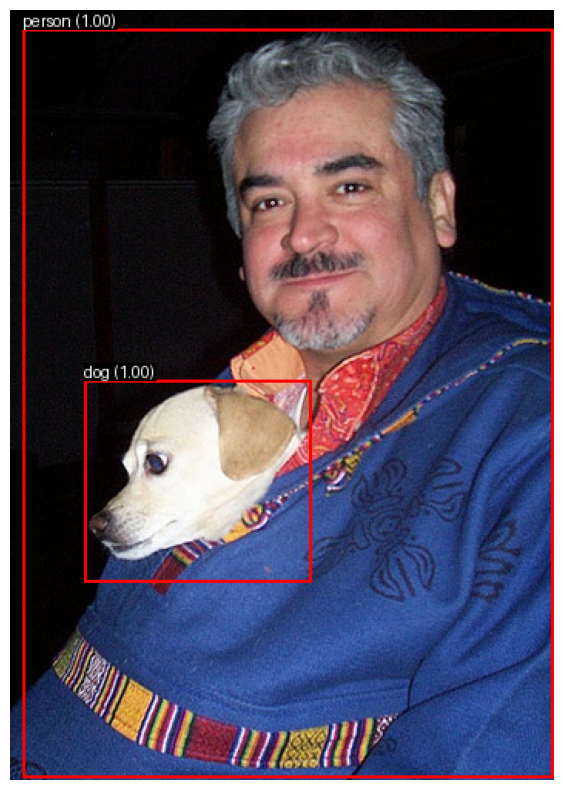

In [17]:
img_path = "./data/VOCdevkit/VOC2007/JPEGImages/000001.jpg"  # Change to an actual image path
xml_path = "./data/VOCdevkit/VOC2007/Annotations/000001.xml"  # Change to corresponding XML path

idx_to_class = {v: k for k, v in class_to_idx.items()}

image = Image.open(img_path).convert("RGB")
boxes, labels = parse_voc_annotation(xml_path, class_to_idx)
gt_class_names = [idx_to_class[label] for label in labels]


# Draw the ground truth bounding boxes
image_with_boxes = draw_predictions(image, boxes, labels=gt_class_names, scores=[1.0]*len(boxes), color="red")

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image_with_boxes)
plt.axis("off")
plt.show()


#### 2.5 Анализ False Positives / False Negatives

Для измерения того, насколько хорошо bounding box предсказан, применяется параметр IoU (Intersection over Union) между двумя bounding boxes. Чем он выше, тем точнее предсказание. Для его оценки опишем следующий метод, принимающий два np.array-объекта (прогнозные и истинные координаты):

In [18]:
def calculate_iou(pred_box, gt_box):
    x1, y1, x2, y2 = pred_box
    x1g, y1g, x2g, y2g = gt_box

    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

#### 2.6 Оценка модели и визуализация результатов

Выполните прямой проход нескольких изображений через модель. Для этого необходимо загрузить изображения и аннотации, применить преобразование изображений в тензор. Затем получите выходы модели:

In [19]:
def compute_iou(boxA, boxB):
    # Compute IoU between two sets of bounding boxes
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

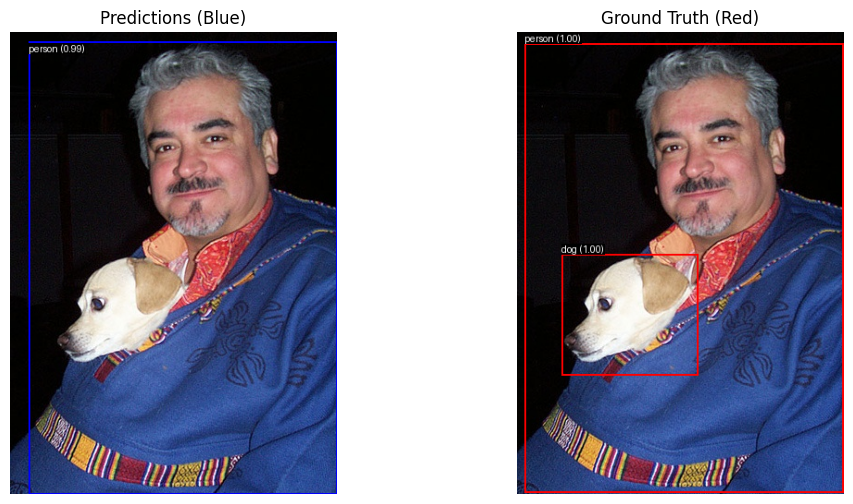

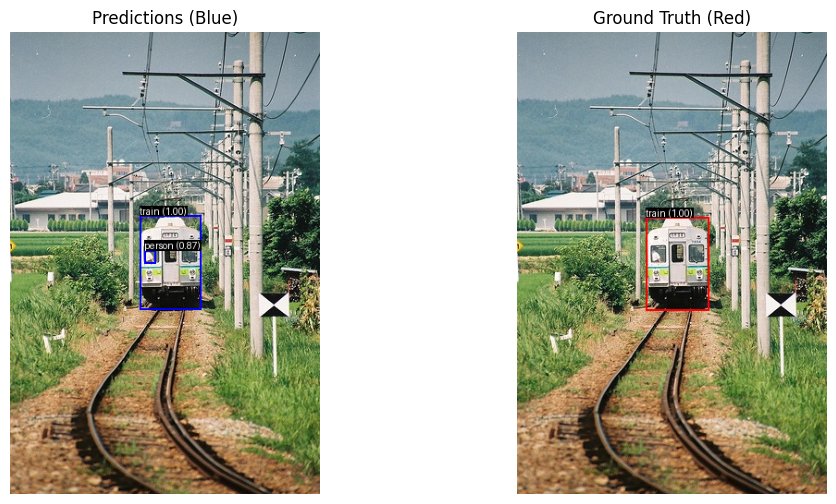

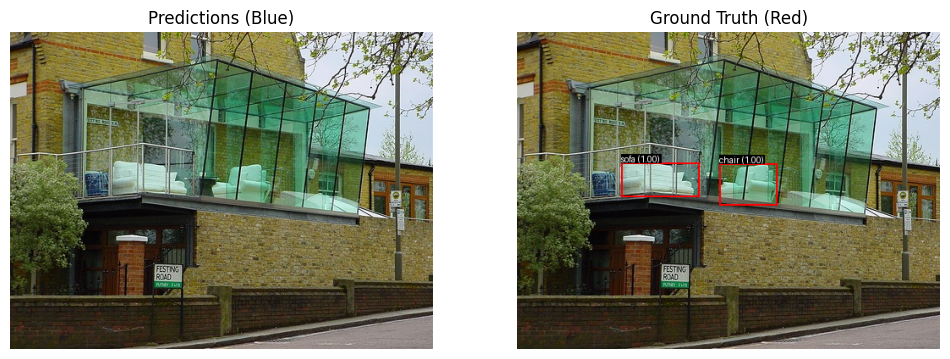

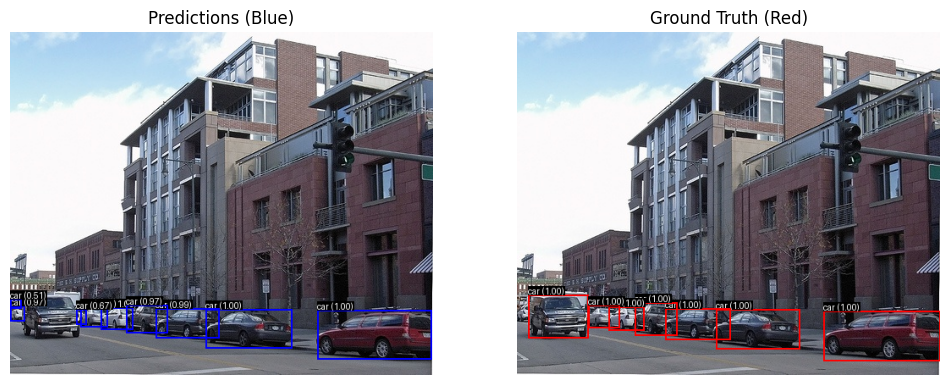

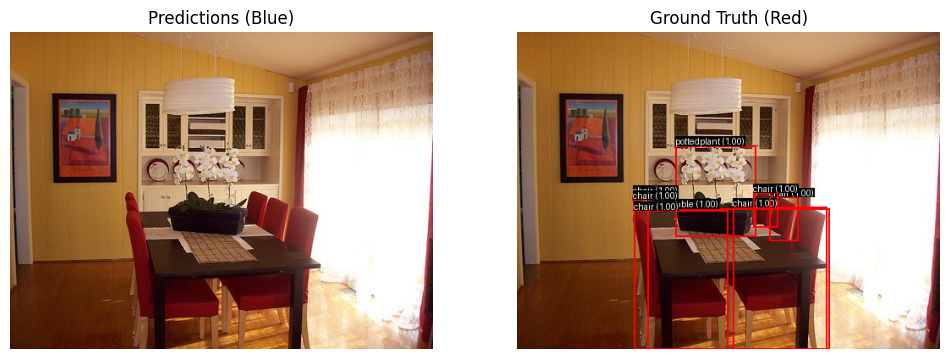

In [20]:
# выберите N изображений 5 из датасета
image_filenames = [test_dataset[i][1]['annotation']['filename'] for i in range(5)]

image_paths = [f"./data/VOCdevkit/VOC2007/JPEGImages/{filename}" for filename in image_filenames]
annotation_paths = [f"./data/VOCdevkit/VOC2007/Annotations/{filename.replace('.jpg', '.xml')}" for filename in image_filenames]

true_positives = 0
false_positives = 0
false_negatives = 0
#true_negatives = 0  # In object detection, this is usually not considered but let's try to count it

iou_threshold = 0.5  # IoU threshold

matched_gt_boxes = set()

# объявите цикл для проверки
for img_path, ann_path in zip(image_paths, annotation_paths):
    matched_gt_boxes = set()

    # загрузите изображение и его разметку
    image = Image.open(img_path).convert("RGB")

    # Get the dimensions of the image (width and height)
    image_width, image_height = image.size

    # Calculate the image area (width * height)
    image_area = image_width * image_height

    gt_boxes, gt_labels = parse_voc_annotation(ann_path, class_to_idx)
    gt_scores = np.ones(len(gt_boxes))  # Assign a default score of 1.0
    gt_class_names = [idx_to_class[label] for label in gt_labels]


    # примените трансформации
    image_tensor = transform(image).unsqueeze(0).to(device) #don't get why i need to do this transformation, cause image already a tensor

    # выполните прямой проход
    with torch.no_grad():
        outputs = model(image_tensor)

    # извлекаем bounding boxes, метки и confidence scores из полученных выходов модели
    pred_label_idxs, pred_scores, pred_boxes = coco_to_pascal_VOC_prediction(outputs[0]['labels'], outputs[0]['scores'], outputs[0]['boxes'], coco_dict)
    pred_labels = [voc_classes[int(idx)] for idx in pred_label_idxs]

    # отрисуйте bounding boxes на изображении с предсказаниями
    image_with_preds = draw_predictions(image.copy(), pred_boxes, pred_labels, pred_scores, color="blue")

    # отрисуйте bounding boxes с реальной разметкой
    image_with_gt = draw_predictions(image.copy(), gt_boxes, gt_class_names, gt_scores, color="red")

    # вычислите IoU для выбранных изображений
    iou_values = []

    # True Positives & False Positives
    for pred_box in pred_boxes:
        match_found = False
        best_iou = 0
        best_match = None

        for gt_idx, gt_box in enumerate(gt_boxes):
            iou = compute_iou(pred_box, gt_box)

            if iou > iou_threshold and iou > best_iou and gt_idx not in matched_gt_boxes:
                best_iou = iou
                best_match = gt_idx

        if best_match is not None:
            matched_gt_boxes.add(best_match)
            true_positives += 1
        else:
            false_positives += 1

    # False Negatives (Unmatched GT Boxes)
    false_negatives += sum(1 for i in range(len(gt_boxes)) if i not in matched_gt_boxes)



    # Display the images with bounding boxes
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(image_with_preds)
    axs[0].set_title("Predictions (Blue)")
    axs[0].axis("off")

    axs[1].imshow(image_with_gt)
    axs[1].set_title("Ground Truth (Red)")
    axs[1].axis("off")

    plt.show()


#### 2.7 Поиск оптимальной конфигурации

Проанализируйте полученные результаты с выбранным значением фильтрации предсказаний. Проведите исследование с целью поиска оптимального порога и баланса FN/FP. Обоснуйте полученные результаты:

In [21]:
# исследование
# Calculate Precision, Recall, and F1-Score
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

accuracy = (true_positives) / (true_positives + false_positives + false_negatives) if (true_positives + false_positives + false_negatives) > 0 else 0

# Print final False Positive and False Negative count
print(f"Total False Positives: {false_positives}")
print(f"Total False Negatives: {false_negatives}")
print(f"Total True Positives: {true_positives}")

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")


Total False Positives: 4
Total False Negatives: 12
Total True Positives: 8
Precision: 0.6667
Recall: 0.4000
F1-Score: 0.5000
Accuracy: 0.3333
